# Predicción de Cáncer de Seno

En este notebook se realizará un modelo que permita diagnosticar la existencia de cáncer de seno. Los datos para este ejercicio son tomados de [Kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data) y son variables obtenidas a partir de imágenes digitales de masas en los senos. Según la fuente, estos datos son características de los núcleos presentes en las células de la imagen.

Para llevar a cabo este ejercicio se construirá un modelo de Red Neuronal Artificial de clasificación binaria.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from metrics import plot_confusion_matrix 
from sklearn.metrics import f1_score, accuracy_score

# 1. Carga de Información y Exploración de Datos

Al cargar la información se puede notar que se cuenta con 33 columnas de información. La variable de interés corresponde a "diagnosis", que toma el valor de "M" cuando el tumor que se encuentra es de caracter maligno, y "B" cuando es benigno.

Se cuenta con un total de 560 observaciones de mediciones sobre imágenes diagnósticas.

In [2]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
len(df)

569

In [4]:
df['cancer'] = 1*(df['diagnosis'] == 'M')

Se puede observar que de las 569 observaciones, sólo el 37% contiene cáncer de seno. Esto implica que si bien existe un desbalance de clases, este no es tan fuerte y posiblemente no sea necesario recurrir a métodos de upsampling o downsampling. 

Adicionalmente, se puede notar la diversidad en las escalas de las variables. Como el objetivo es realizar un modelo de red neuronal, es importante normalizar las variables de forma que las escalas no sean tan disímiles. 

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


# 2. Train-Test Split

En esta sección se realiza la partición entre entrenamiento, validación y prueba. Se realizará una partición inicial del dataset en 80-20%. De forma que se utilizará el 80% de la información para entrenar y validar el modelo, y el 20% restante se utilizará para conocer el desempeño del modelo a la hora de predecir el cáncer de seno en datos nuevos. 

In [6]:
X_features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

y_label = 'cancer'

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y_label], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
print(f'Tamaño de Información:\nEntrenamiento: {round(len(X_train)/len(df)*100, 1)}%. Target: ({round(np.mean(y_train)*100)}%)\n   Validación: {round(len(X_val)/len(df)*100, 1)}%. Target: ({round(np.mean(y_val)*100)}%)\n       Prueba: {round(len(X_test)/len(df)*100, 1)}%. Target: ({round(np.mean(y_test)*100)}%)')

Tamaño de Información:
Entrenamiento: 64.0%. Target: (37%)
   Validación: 16.0%. Target: (40%)
       Prueba: 20.0%. Target: (38%)


Se puede notar que la concentración del cancer es similar en los tres conjuntos que forman la partición del dataset.

# 3. Reescalado de Información

Anteriormente se vio que las variables obtenidas de las imágenes presentan escalas muy diferentes. Con algunas cuya escala está entre 0 y 1, y otras como area_worst que va desde 185 hasta 4254. Por esta razón, se decide hacer un Min-Max Scaler. De esta forma, las variables estarán en el intervalo [0, 1], facilitando a la velocidad de convergencia del modelo de red neuronal.

Este Min-Max scaler será construído tomando los valores máximos y mínimos de cada variable del *conjunto de entrenamiento*, y utilizando estas se transformarán las variables de entrenamiento, validación y prueba.

In [9]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 4. Modelo de Red Neuronal para Clasificación Binaria

En este apartado se realizará la construcción y estimación de red neuronal. Este modelo tendrá como entrada 32 variables (cada una de las mediciones obtenidas de las imágenes), pasarán por una capa oculta compuesta por 10 neuronas para reducir su dimensón y posteriormente pasarán a la capa de salida que consta de dos neuronas con activación sigmoid para el problema de clasificación. 

Esta red neuronal buscará optimizar la función de pérdida "Binary Crossentropy", dada por, 

$$H_p(q) = \frac{-1}{N} \sum_{i = 1}^{N} y_i log(\hat{p}_i) + (1 - y_i) log(1-\hat{p}_i)$$

donde $y_i$ es una variable binaria que toma el valor de 1 si el registro $i$ presenta cáncer y 0 de lo contrario. \hat{p} corresponde a la probabilidad estimada de que el $i$-éstimo registro tenga cáncer. Optimizar directamente esta función permite que el modelo de red neuronal esté más seguro de sus predicciones. 

In [10]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Adicionalmente, este modelo será entrenado con una regla de EarlyStopping. De esta forma, el entrenamiento es detenido después de 3 epochs en que la pérdida en el conjunto de validación  no disminuya, previniendo un posible sobreajuste del modelo a los datos de entrenamiento. 

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks = [earlystopping_callback], verbose = 1)

Epoch 1/100
12/12 [==============================] - 1s 58ms/step - loss: 0.7433 - accuracy: 0.3588 - val_loss: 0.7084 - val_accuracy: 0.3956
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.3825 - val_loss: 0.6848 - val_accuracy: 0.3956
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6728 - accuracy: 0.3815 - val_loss: 0.6681 - val_accuracy: 0.3956
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.4179 - val_loss: 0.6545 - val_accuracy: 0.4835
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 0.6469 - accuracy: 0.5701 - val_loss: 0.6429 - val_accuracy: 0.6484
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.7283 - val_loss: 0.6311 - val_accuracy: 0.7802
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.8011 - val_loss: 0.6198 - val_accuracy: 0.8352
Epoch 8/100

Se observa que el modelo no se detuvo antes de las 100 epochs, y que la pérdida seguía disminuyendo aún en en la epoch 100. Esto da indicios de que aún se puede mejorar el desempeño de la red. Sin embargo, se observa que en validación este modelo de red alcanzó una precisión de 92.3%. 

# 6. Evaluación del Modelo

En esta sección se realiza la evaluación del modelo anteriormente entrenado. Para esto se realizará un gráfico del entrenamiento de la red neuronal para asegurar que no hubo luagar al sobreajuste durante el entrenamiento. 

In [13]:
metrics = pd.DataFrame(model.history.history)

## 6.1 Evolución de Accuracy

Se observa que durante las 100 epochs del modelo, el accuracy de entrenamiento (línea azul) estuvo por encima de la de validación (naranja), pero estando siempre cerca. De forma que la red estuvo aprendiendo constantemente de los ejemplos que se le dio, sin haberlos memorizado. 

<AxesSubplot:>

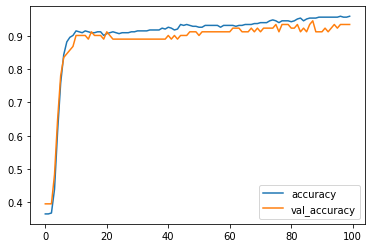

In [14]:
metrics[['accuracy', 'val_accuracy']].plot()

## 6.2 Evolución de Pérdida

Por el lado de la pérdida, se observa que tuvo un decrecimiento suave y constante a lo largo de las 100 epochs del modelo. La tendencia de la pérdida en validación da a entender que posiblemente en las próximas epochs habría convergido a un nivel cerano al 0.2 y el EarlyStopping la hubiera detenido. 

En este gráfico tampoco se observan señales de sobreajuste.

<AxesSubplot:>

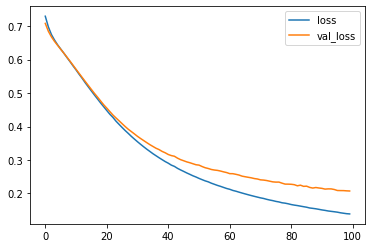

In [15]:
metrics[['loss', 'val_loss']].plot()

# 7. Desempeño en Test
En esta sección se analizará el desempeño del modelo en la base de test que se dejó por fuera para analizar cómo se compartará el modelo en datos nunca antes vistos. 

A continuación se generan las predicciones de los individuos en X_test. Se define que toda predicción superior a 0.5 se entiende como diagnóstico de cáncer ($\hat{y}_i = 1$), e inferior a 0.5 como no diagnóstico de cáncer ($\hat{y}_i = 0$).

In [16]:
y_pred = model.predict_classes(X_test)
y_true = y_test.values

## 7.1 Matriz de Confusión

A continuación se presenta la matriz de confusión del modelo. Se puede observar que predice los verdaderos negativos (sin cáncer) con un acierto de 97%, y los verdaderos positivos (con cáncer) con un acierto de 95%. De esta forma, se tiene un modelo que es bueno discriminando entre las dos clases, y no tiende casi a confundirse. 

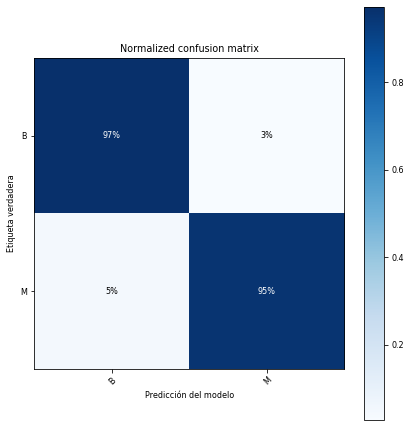

In [17]:
plot_confusion_matrix(y_true, y_pred, np.unique(df.diagnosis.values), normalize=True)
plt.show()

# 7.2 Accuracy y F1 Score

A continuación se calcula el Accuracy del modelo y su correspondiente macro F1-score. 

En primer lugar, se tiene que el modelo detectó los casos de cancer (y no cáncer) con una exactitud del 96.4%. Este valor no es sorprendente, dado que ya se conoce la capacidad del modelo para discriminar entre las dos categorías. Sin embargo, los errores que tiene disminuyen la confiabilidad del modelo, dejando un F1-Score de 96.2%. 

En general, el modelo construido permite clasificar con bastante exactitud si un paciente presenta tumores nmalignos a partir de sus imágenes diagnósticas. 

Este modelo todavía puede ser mejorado ligeramente gracias a que la curva de pérdida seguía disminuyendo en el momento en que se detuvo el entrenamiento. 

In [19]:
accuracy_score(y_true, y_pred)

0.9649122807017544

In [18]:
f1_score(y_pred, y_true, average = 'macro')

0.9626596790042581